**Importing some important libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Lets consider the green data for January 2018**

In [2]:
#df = pd.read_csv('yellow_tripdata_2018-01.csv')
#df = pd.read_csv('green_tripdata_2018-01.csv')
df = pd.read_csv('green_2017_20%.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348134 entries, 0 to 2348133
Data columns (total 19 columns):
VendorID                 int64
lpep_pickup_datetime     object
lpep_dropoff_datetime    object
store_and_fwd_flag       object
RatecodeID               int64
PULocationID             int64
DOLocationID             int64
passenger_count          int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type             int64
trip_type                float64
dtypes: float64(10), int64(6), object(3)
memory usage: 340.4+ MB


Looks like `ehail_fee` is useless column, its 0 all the time, lets drop it at the moment!

In [4]:
df.drop('ehail_fee', inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348134 entries, 0 to 2348133
Data columns (total 18 columns):
VendorID                 int64
lpep_pickup_datetime     object
lpep_dropoff_datetime    object
store_and_fwd_flag       object
RatecodeID               int64
PULocationID             int64
DOLocationID             int64
passenger_count          int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
payment_type             int64
trip_type                float64
dtypes: float64(9), int64(6), object(3)
memory usage: 322.5+ MB


Let's have a quick look on the `store_and_fwd_flag` column

In [5]:
df.store_and_fwd_flag.unique(), df.store_and_fwd_flag.value_counts()

(array(['N', 'Y'], dtype=object), N    2344735
 Y       3399
 Name: store_and_fwd_flag, dtype: int64)

`store_and_fwd_flag` is either the customer was dispatched or a flag.<br>
Let's convert this to `1/0 ==> N = 1, Y = 0` with new column name `dispatch`. **Notice that dispatch is common type of trip**<br>
Another thing we can see, which day the flag is more than dispatch, probability if higher for the flag is on weekends nights!<br>
Let's write a custom function to convert the categorical col to 1/0

In [6]:
def cat_to_num(x):
    if x.lower() == 'n':
        return 1
    if x.lower() == 'y':
        return 0

In [7]:
df['dispatch'] = df['store_and_fwd_flag'].apply(cat_to_num)

In [8]:
df.dispatch.value_counts()

1    2344735
0       3399
Name: dispatch, dtype: int64

We can drop `store_and_fwd_flag`, we don't need it anymore after `dispatch` column.

In [9]:
df.drop('store_and_fwd_flag', inplace=True, axis=1)

I don't know what is VendorID! **However**, we can consider two dispatch companies, this could be another feature and suggest the preferred company to call for a cab. 

In [10]:
df.VendorID.value_counts()

2    1888895
1     459239
Name: VendorID, dtype: int64

In [11]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,dispatch
0,2,2017-01-06 11:07:56,2017-01-06 11:13:00,1,75,41,2,1.36,6.5,0.0,0.5,0.00,0.0,0.3,7.30,2,1.0,1
1,1,2017-05-18 04:00:07,2017-05-18 04:02:34,1,95,95,1,0.70,4.0,0.5,0.5,1.30,0.0,0.3,6.60,1,1.0,1
2,2,2017-02-21 22:59:17,2017-02-21 23:03:47,1,196,56,5,0.87,5.5,0.5,0.5,0.00,0.0,0.3,6.80,2,1.0,1
3,2,2017-12-22 19:05:09,2017-12-22 19:32:57,1,65,225,2,4.65,20.5,1.0,0.5,4.46,0.0,0.3,26.76,1,1.0,1
4,2,2017-11-12 06:21:34,2017-11-12 06:29:59,1,82,95,5,2.17,9.0,0.0,0.5,0.00,0.0,0.3,9.80,2,1.0,1


**Dealing with `lpep_pickup_datetime & lpep_dropoff_datetime`** Columns<br>
* Separate dates and time from both columns.
* Some trips started in one date and end on the next date, we can avoid them to keep the things simple
* drop the original columns 

new columns will be <br>
* PUD -- PickUp Date
* PUT -- PickUp Time
* DOD -- DropOff Date
* DOT -- DropOff Time

In [12]:
df['PUD'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.date
df['PUT'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.time
df['DOD'] = pd.to_datetime(df['lpep_dropoff_datetime']).dt.date
df['DOT'] = pd.to_datetime(df['lpep_dropoff_datetime']).dt.time
df.drop(['lpep_pickup_datetime','lpep_dropoff_datetime'], axis = 1, inplace =True)

In [13]:
df = df[df['DOD'] == df['PUD']]

I think, now we don't need two dates now, we can create rename either (DOD or PUD) to data and delete the other!

In [14]:
df['date']=df['DOD']
df.drop(['DOD','PUD'], inplace = True, axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314057 entries, 0 to 2348133
Data columns (total 19 columns):
VendorID                 int64
RatecodeID               int64
PULocationID             int64
DOLocationID             int64
passenger_count          int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
payment_type             int64
trip_type                float64
dispatch                 int64
PUT                      object
DOT                      object
date                     object
dtypes: float64(9), int64(7), object(3)
memory usage: 353.1+ MB


**Comment please**<br>
We can create a column for a common hour  for pick-ups and drop-offs in some way (e.g. rounding the ride to the previous hour for some mins in the next hours say 15 mins). This way, we can make the data simple and count no of rides in each hour. A bar plot can tell us the busy hours that will schedule available resources (in this case no of cabs) on the respective time (we can add zone here as well). 

In [16]:
df.RatecodeID.value_counts()

1     2264394
5       41826
2        5021
4        1423
3        1351
6          35
99          7
Name: RatecodeID, dtype: int64

**Comments please**<br>
Once again, there are 7 rate codes, it is clear that the regular code '1' is maximum rides. It is great if we can find this information from the website. We can use these codes as is for ML part but for EDA, its good to suggest which code is for what type of customer. If we could not find any info, we can self suggest the codes, no problem!

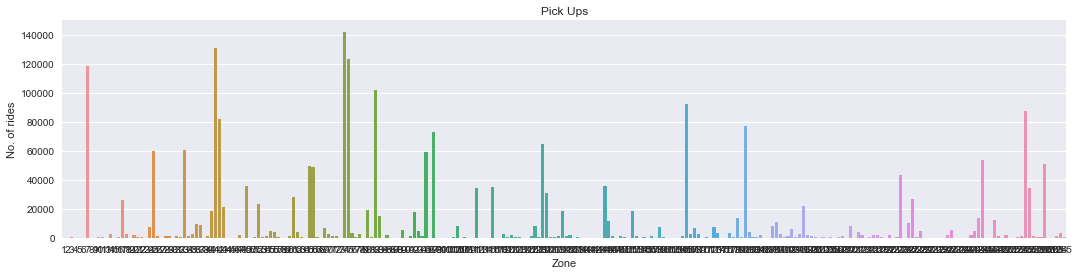

In [24]:
fig, ax = plt.subplots(figsize = (18,4))
sns.barplot(df.PULocationID.value_counts().index, df.PULocationID.value_counts().values, ax = ax)
ax.set_ylim(0,150000);
ax.set_ylabel('No. of rides')
ax.set_xlabel('Zone')
ax.set_title('Pick Ups')

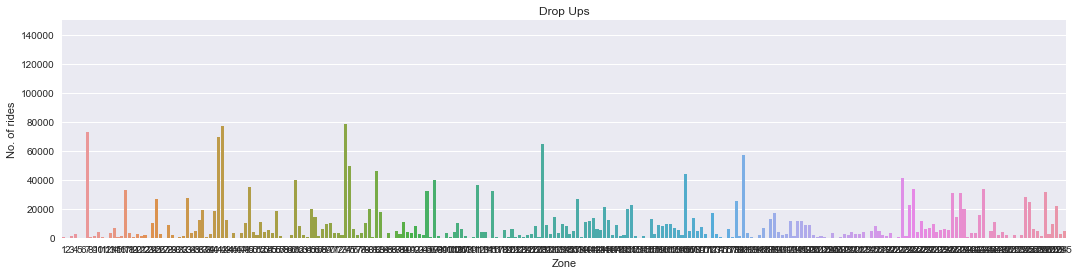

In [25]:
fig, ax = plt.subplots(figsize = (18,4))
sns.barplot(df.DOLocationID.value_counts().index, df.DOLocationID.value_counts().values, ax = ax)
ax.set_ylim(0,150000);
ax.set_ylabel('No. of rides')
ax.set_xlabel('Zone')
ax.set_title('Drop Ups')

The plots above may not look very good at the moment, however, they are suggesting the regions for the most calls. If we plot them w.r.t the time, we can see the flow of customer and get an idea of the commercial and residential zones. Remember, people living close to their offices have low probability to take cab.<br>
We may need to think about some kind of aggregation for these plots so that they look good. We can use custom pellet with selected colors to convey message.<br>
Another idea is to re-zone the city, which might not be a realistic thing because you never know how the zones are divided. Sometime, adjacent zones could have very different numbers, however this is not common in cab industry. <br>
We might be able to get a correlation for selected features in a heatmap....we can think about it.

In [19]:
df.to_csv('green_clean_2017_1.csv', index=False)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314057 entries, 0 to 2348133
Data columns (total 19 columns):
VendorID                 int64
RatecodeID               int64
PULocationID             int64
DOLocationID             int64
passenger_count          int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
payment_type             int64
trip_type                float64
dispatch                 int64
PUT                      object
DOT                      object
date                     object
dtypes: float64(9), int64(7), object(3)
memory usage: 353.1+ MB


In [21]:
df.head()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,dispatch,PUT,DOT,date
0,2,1,75,41,2,1.36,6.5,0.0,0.5,0.00,0.0,0.3,7.30,2,1.0,1,11:07:56,11:13:00,2017-01-06
1,1,1,95,95,1,0.70,4.0,0.5,0.5,1.30,0.0,0.3,6.60,1,1.0,1,04:00:07,04:02:34,2017-05-18
2,2,1,196,56,5,0.87,5.5,0.5,0.5,0.00,0.0,0.3,6.80,2,1.0,1,22:59:17,23:03:47,2017-02-21
3,2,1,65,225,2,4.65,20.5,1.0,0.5,4.46,0.0,0.3,26.76,1,1.0,1,19:05:09,19:32:57,2017-12-22
4,2,1,82,95,5,2.17,9.0,0.0,0.5,0.00,0.0,0.3,9.80,2,1.0,1,06:21:34,06:29:59,2017-11-12
